In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("../../MG5/Delphes/")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


# Set Delphes output files

In [17]:
inputFiles = {'zp_dm': '../Tests/2mdm_spin1/Events/run_01/zp_2000_delphes_events.root',
              'sd_dm': '../Tests/2mdm_spin0/Events/run_12/sd_700_delphes_events.root'}

cmsData = pd.read_pickle('../data/DMsimp_spin-1_Monojet_DF.pcl')
cmsData.rename(columns = {'$m_{med}$':'$M_{med}$', '$m_{DM}$':'$m_{\chi}$', '$g_{DM}$':'$g_{\chi}$'}, 
                inplace=True)

# Load model parameters

In [18]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    
    
    if 9900032 in pars.blocks['MASS']:
        model = '2mdm'        
        mZp = pars.blocks['MASS'][9900032] # Z prime mass
        
    elif 55 in pars.blocks['MASS']:
        model = 'dmsimp'
        mZp = pars.blocks['MASS'][55] # Z prime mass
        
    
    if model == '2mdm':
        mS = pars.blocks['BLINPUTS'][2] # dark Higgs (S) mass
        mChi = pars.blocks['MASS'][9000006] # DM mass
        sTheta = pars.blocks['BLINPUTS'][3] # sin theta
        ychi = pars.blocks['FRBLOCK'][1] # coupling of S to DM
        gchi = pars.blocks['ZPRIME'][1] # coupling of mediators to DM
        gq = pars.blocks['ZPRIME'][2] # coupling of mediators to SM
    elif model == 'dmsimp':
        mS = np.nan # dark Higgs mass
        mChi = pars.blocks['MASS'][52] # DM mass
        sTheta = 0
        gchi = pars.blocks['DMINPUTS'][2] # coupling of mediators to DM
        gq = pars.blocks['DMINPUTS'][6] # coupling of mediators to SM  
        

    
        
    parameters[label] = {'mZp' : mZp, 'mDM' : mChi, 'mH2' : mS,
                         'gq' : gq, 'sTheta' : sTheta, 'gx' : gchi, 'ychi' : ychi}
    print(label,': mZp = %1.2f GeV, mH2 = %1.2f GeV, mDM = %1.2f GeV' %(mZp,mS,mChi))

zp_dm : mZp = 2000.00 GeV, mH2 = 200.00 GeV, mDM = 65.00 GeV
sd_dm : mZp = 2000.00 GeV, mH2 = 700.00 GeV, mDM = 65.00 GeV


# Load events, apply cuts, and store info

In [19]:
# ## Cuts
## MET
pTcut = 150.
## jets
pTj1min = 100.
pTjmin = 20.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Photons
pTmin_a = 15.
etamax_a = 2.5
nMax_a = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0
## Tau jets
nMax_tau = 0
etatau_max = 2.3
pTtau_min = 18.0
## b jets
nMax_b = 0
etab_max = 2.4
pTb_min = 20.0

In [20]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}

for label,inputFile in inputFiles.items():
    
    f = ROOT.TFile(inputFile, 'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts
    
    for event in range(nevts):
        
        tree.GetEntry(event)

        jets = tree.Jet
        
        try:
            weight = tree.Weight.At(1).Weight
        except:
            weight = tree.Weight.At(0).Weight
            
        totalweight[label] += weight
        
        missingET = tree.MissingET.At(0)
        electrons = tree.Electron
        muons = tree.Electron
        photons = tree.Photon
        
        # Filter electrons:
        electronList = []
        for iel in range(electrons.GetEntries()):
            electron = electrons.At(iel)
            
            if electron.PT < pTmin_el: continue
            if abs(electron.Eta) > etamax_el: continue
                
            electronList.append(electron)
        
        # Filter muons:
        muonList = []
        for imu in range(muons.GetEntries()):
            muon = muons.At(imu)
            
            if muon.PT < pTmin_mu: continue
            if abs(muon.Eta) > etamax_mu: continue
                
            muonList.append(muon)
            
        # Filter photons:
        photonList = []
        for ia in range(photons.GetEntries()):
            photon = photons.At(ia)
            
            if photon.PT < pTmin_a: continue
            if abs(photon.Eta) > etamax_a: continue
                
            photonList.append(photon)
        
        # Filter jets
        jetList = []
        bjetList = []
        taujetList = []
        for ijet in range(jets.GetEntries()):
            jet = jets.At(ijet)
            
            if (jet.BTag) and (jet.PT > pTb_min) and (abs(jet.Eta) < etab_max):
                bjetList.append(jet)
            elif (jet.TauTag) and (jet.PT > pTtau_min) and (abs(jet.Eta) < etatau_max):
                taujetList.append(jet)
            elif (jet.PT > pTj1min) and (abs(jet.Eta) < etamax):
                jetList.append(jet)
        jetList = sorted(jetList, key= lambda j: j.PT, reverse= True)
        
        njets[label] = np.append(njets[label], jets.GetEntries())
        
        if len(jetList) > 0:
            deltaPhi = np.abs(jetList[0].Phi-missingET.Phi)
        else:
            deltaPhi = 0.0
            
        # Apply cuts
        # cut on MET at parton level
        dmMET = tree.DMMissingET.At(0).MET
        if dmMET < pTcut: continue
        # veto electrons
        if len(electronList) > nMax_el: continue
        # veto muons
        if len(muonList) > nMax_mu: continue
        # veto tau jets
        if len(taujetList) > nMax_b: continue
        # veto photons
        if len(photonList) > nMax_a: continue
        # cut on delta phi
        if deltaPhi < 0.5: continue
        # jet cuts
        if (len(jetList) < 1) or (jetList[0].PT < pTj1min): continue
        if abs(jetList[0].Eta) > etamax: continue
            
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        pTj1[label] = np.append(pTj1[label],jetList[0].PT)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label], dmMET)
        
        
f.Close()
        

In [21]:
met

{'zp_dm': array([958.28979492, 599.37329102, 367.29541016, ..., 190.24624634,
        429.01535034, 500.57049561]),
 'sd_dm': array([459.84597778, 378.63705444, 369.37835693, ..., 431.32635498,
        316.07540894, 326.74612427])}

In [22]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(weights.keys())}    

zp_dm total cross-section = 1.382e-01 pb
sd_dm total cross-section = 2.684e-03 pb


In [23]:
## Filter CMS data

modelFilter = { 
 'Coupling' : 'Vector',
 '$M_{med}$' : 2500.0,
 '$m_{\chi}$' : 1.0,
 '$g_{\chi}$' : 1.0,
 '$g_{q}$' : 0.25}


dfModel = cmsData.loc[(cmsData[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
dfModel = dfModel[dfModel['Data-takingperiod'] == 2017]

In [24]:
# Auxiliar function for plotting
def getBins(dfModel,rightBin = 1400.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft

def getMETbins(dfSingle,bins,binsError):

    data = {c : dfSingle[c].iloc[0] for c in bins}
    dataError = {c : dfSingle[c].iloc[0] for c in binsError}

    return data,dataError


In [25]:
bins,binsError,binCenter,binLeft = getBins(dfModel)
data, dataError = getMETbins(dfModel,bins,binsError)
ptCMS = np.array([data[c] for c in bins])

In [26]:
lum2017 = 41.5 #fb^-1
binned = {}
metBins = [250,  280,  310,  340,  370,  400,  430,  470,  510, 550,  590,  640,  690,  
            740,  790,  840,  900,  960, 1020, 1090, 1160, 1250, 99999]
for label, pt in pTj1.items():
#     binned[label], bins2 = np.histogram(pt, bins=binLeft, weights=weights[label])
    binned[label], bins2 = np.histogram(pt, bins=metBins, weights=weights[label]*1e3*lum2017)
k=1
brZ = 0.639069
brS = 0.9018403
ptTotal = binned['zp_dm'] + binned['sd_dm']


In [27]:
# legend
legend = {
          'Coupling' : 'Vector',
          '$m_{Z^{\prime}}$' : 2500.0,
          '$m_{s}$' : 300.0,
          '$g_{\chi}$' : 1.0,
          '$g_{q}$' : 0.1,
          '$y_{\chi}$' : 1.5,
          '$\sin\\alpha$' : 0.2
           }
textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in legend.items()])

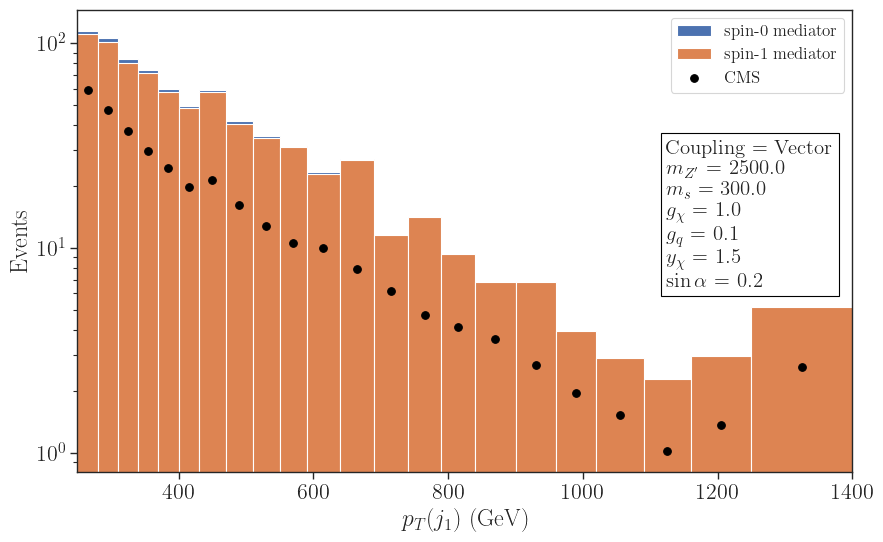

In [28]:
fig = plt.figure(figsize=(10,6))

plt.hist(binCenter, bins=metBins, weights=ptTotal, stacked=True, 
         label=r'spin-0 mediator')
# plt.hist(binCenter, bins=binLeft, weights=binned['y1_dm'], stacked=False, label='y1_dm')
plt.hist(binCenter, bins=metBins, weights=k*binned['zp_dm'], stacked=True, 
         label=r'spin-1 mediator')
 
plt.scatter(x=binCenter, y=ptCMS, s=30, color='black', label='CMS')
    
plt.yscale('log')
# plt.ylim(1e0,3e2)
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel(r'Events')
plt.xlim(250,1400)
plt.legend(loc='upper right', fontsize='x-small')

plt.text(0.76,0.4,textstr,fontsize=15,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

# plt.savefig('../../Pictures/plot-pt.png')
plt.show()